# ARIMA Modelling: Forecasting Weekly Hotel Cancellations

# Milestone 1

The below defines the procedures for forming the weekly time series as specified.

### Import Libraries and define dtypes

In [1]:
import csv
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pmdarima as pm
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf

from numpy.random import seed
seed(1)
from pandas import DataFrame
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.stattools as ts

dtypes = {
        'IsCanceled':                                    'float64',
        'LeadTime':                                          'float64',
        'StaysInWeekendNights':                                     'float64',
        'StaysInWeekNights':                                     'float64',
        'Adults':                            'float64',
        'Children':                            'float64',
        'Babies':                                  'float64',
        'Meal':                                    'category',
        'Country':                                               'category',
        'MarketSegment':                                    'category',
        'DistributionChannel':                                       'category',
        'IsRepeatedGuest':                               'float64',
        'PreviousCancellations':                                    'float64',
        'PreviousBookingsNotCanceled':                          'float64',
        'ReservedRoomType':                                             'category',
        'AssignedRoomType':                                            'category',
        'BookingChanges':                                                'float64',
        'DepositType':                                              'category',
        'Agent':                                              'category',
        'Company':                                 'category',
        'DaysInWaitingList':                                           'float64',
        'CustomerType':                                           'category',
        'ADR':                                          'float64',
        'RequiredCarParkingSpaces':                                      'float64',
        'TotalOfSpecialRequests':                                              'float64',
        'ReservationStatus':                                                'category'
        }

### Data is sorted by year and week number

In [2]:
train_df = pd.read_csv('H1.csv', dtype=dtypes, converters={'ArrivalDateWeekNumber': '{:0>2}'.format})
a=train_df.head()
b=train_df
b
c=b.sort_values(['ArrivalDateYear','ArrivalDateWeekNumber'], ascending=True)
c=pd.DataFrame(c)
c
type(c)

pandas.core.frame.DataFrame

In [3]:
c

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0.0,342.0,2015,July,27,1,0.0,0.0,2.0,0.0,...,No Deposit,NULL,NULL,0.0,Transient,0.00,0.0,0.0,Check-Out,2015-07-01
1,0.0,737.0,2015,July,27,1,0.0,0.0,2.0,0.0,...,No Deposit,NULL,NULL,0.0,Transient,0.00,0.0,0.0,Check-Out,2015-07-01
2,0.0,7.0,2015,July,27,1,0.0,1.0,1.0,0.0,...,No Deposit,NULL,NULL,0.0,Transient,75.00,0.0,0.0,Check-Out,2015-07-02
3,0.0,13.0,2015,July,27,1,0.0,1.0,1.0,0.0,...,No Deposit,304,NULL,0.0,Transient,75.00,0.0,0.0,Check-Out,2015-07-02
4,0.0,14.0,2015,July,27,1,0.0,2.0,2.0,0.0,...,No Deposit,240,NULL,0.0,Transient,98.00,0.0,1.0,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40055,0.0,212.0,2017,August,35,31,2.0,8.0,2.0,1.0,...,No Deposit,143,NULL,0.0,Transient,89.75,0.0,0.0,Check-Out,2017-09-10
40056,0.0,169.0,2017,August,35,30,2.0,9.0,2.0,0.0,...,No Deposit,250,NULL,0.0,Transient-Party,202.27,0.0,1.0,Check-Out,2017-09-10
40057,0.0,204.0,2017,August,35,29,4.0,10.0,2.0,0.0,...,No Deposit,250,NULL,0.0,Transient,153.57,0.0,3.0,Check-Out,2017-09-12
40058,0.0,211.0,2017,August,35,31,4.0,10.0,2.0,0.0,...,No Deposit,40,NULL,0.0,Contract,112.80,0.0,1.0,Check-Out,2017-09-14


In [4]:
df = DataFrame(c, columns= ['ArrivalDateYear', 'ArrivalDateWeekNumber']) 
df

,ArrivalDateYear,ArrivalDateWeekNumber
0,2015,27
1,2015,27
2,2015,27
3,2015,27
4,2015,27
...,...,...
40055,2017,35
40056,2017,35
40057,2017,35
40058,2017,35


In [5]:
df1 = df['ArrivalDateYear'].map(str) + df['ArrivalDateWeekNumber'].map(str)
print (df1)
df1=pd.DataFrame(df1)

0        201527
1        201527
2        201527
3        201527
4        201527
          ...  
40055    201735
40056    201735
40057    201735
40058    201735
40059    201735
Length: 40060, dtype: object


### Cancellation entries are joined with the associated date

In [6]:
df2 = DataFrame(c, columns= ['IsCanceled']) 
df2

,IsCanceled
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
40055,0.0
40056,0.0
40057,0.0
40058,0.0


In [7]:
type(df1)

pandas.core.frame.DataFrame

In [8]:
df3=pd.concat([df1, df2], axis = 1)
df3
df3.columns = ['FullDate', 'IsCanceled']

In [9]:
df3
df3.sort_values(['FullDate','IsCanceled'], ascending=True)

,FullDate,IsCanceled
0,201527,0.0
1,201527,0.0
2,201527,0.0
3,201527,0.0
4,201527,0.0
...,...,...
13799,201735,1.0
13800,201735,1.0
13801,201735,1.0
13802,201735,1.0


In [10]:
type(df3)

pandas.core.frame.DataFrame

### Cancellations are aggregated on a weekly basis

In [11]:
df4 = df3.groupby('FullDate').agg(sum)
df4
df4.sort_values(['FullDate'], ascending=True)

,IsCanceled
FullDate,
201527,41.0
201528,48.0
201529,87.0
201530,74.0
201531,101.0
...,...
201731,173.0
201732,140.0
201733,182.0


In [12]:
tseries=df4['IsCanceled']
tseries

FullDate
201527     41.0
201528     48.0
201529     87.0
201530     74.0
201531    101.0
          ...  
201731    173.0
201732    140.0
201733    182.0
201734    143.0
201735    100.0
Name: IsCanceled, Length: 115, dtype: float64

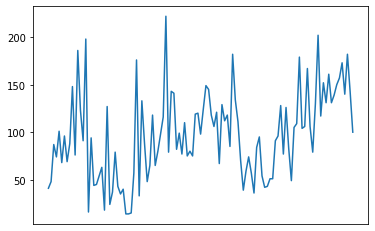

In [13]:
plt.plot(tseries)
plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)
plt.show()

Note the components of each time series as graphed below. This provides important visual signals for the structure of the time series, and is important for a more intuitive understanding of the eventual ARIMA model structure that will be chosen.

# Milestone 2

The time series is decomposed, autocorrelation and partial autocorrelation plots are generated, a 4-week moving average is calculated, and a 90/10 train-test split is conducted.

### Time Series Decomposition

/home/michael/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  """Entry point for launching an IPython kernel.


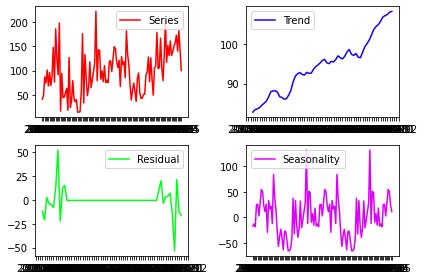

In [14]:
decomposition=seasonal_decompose(tseries, freq = 52)
residual=decomposition.resid
trend=decomposition.trend
seasonal=decomposition.seasonal

plt.subplot(221)
plt.plot(tseries,color='#ff0000', label='Series')
plt.legend(loc='best')
plt.subplot(222)
plt.plot(trend,color='#1100ff', label='Trend')
plt.legend(loc='best')
plt.tight_layout()
plt.subplot(223)
plt.plot(residual,color='#00ff1a', label='Residual')
plt.legend(loc='best')
plt.tight_layout()
plt.subplot(224)
plt.plot(seasonal,color='#de00ff', label='Seasonality')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [15]:
df=pd.DataFrame(tseries)
df

,IsCanceled
FullDate,
201527,41.0
201528,48.0
201529,87.0
201530,74.0
201531,101.0
...,...
201731,173.0
201732,140.0
201733,182.0


In [16]:
acf(tseries, nlags=100)

/home/michael/.local/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


array([ 1.        ,  0.36055904,  0.43832205,  0.40127022,  0.22826716,
        0.24918724,  0.15101187,  0.18028853,  0.24989161,  0.15601839,
        0.07915897,  0.23154771, -0.0169825 , -0.01466523, -0.0033419 ,
       -0.08290528, -0.01984712, -0.135677  , -0.12177448, -0.03335962,
       -0.17835337, -0.13422302, -0.03268604, -0.07548972, -0.0421531 ,
       -0.04994595, -0.10848361, -0.07935225, -0.14858541, -0.21920401,
       -0.07485366, -0.1276737 , -0.08496734, -0.06135381, -0.0346665 ,
       -0.02197916, -0.03738199, -0.0693973 , -0.05242808, -0.10479092,
       -0.05708971, -0.01068735,  0.02521707,  0.07551147,  0.01410364,
        0.10891998,  0.09191396,  0.11836413,  0.08608626,  0.11700134,
        0.16769515,  0.13899503,  0.12283802,  0.16655349,  0.16929214,
        0.09328562,  0.1039967 ,  0.1369494 ,  0.07891873,  0.07031449,
        0.02025803,  0.09896626,  0.03810602, -0.02668274,  0.0050429 ,
        0.01469309, -0.03260927, -0.0384516 , -0.02308869, -0.10

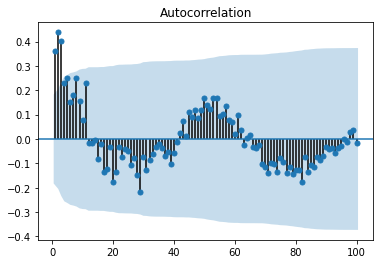

In [17]:
plot_acf(df.IsCanceled, lags=100, zero=False);

In [18]:
pacf(tseries, nlags=100)

/home/michael/.local/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


array([ 1.00000000e+00,  3.63721836e-01,  3.61627367e-01,  2.34558155e-01,
       -6.53247029e-02,  2.88548388e-03, -4.54403247e-02,  7.69701712e-02,
        1.96715414e-01,  1.75407513e-02, -1.94685625e-01,  1.42765724e-01,
       -1.74234695e-01, -1.54066321e-01, -4.05580516e-03, -6.48322467e-03,
        1.41123990e-03, -1.17856389e-01, -1.08754057e-01,  6.51086069e-02,
       -7.74094497e-02,  6.89681438e-03,  1.30870221e-01,  1.24424081e-01,
        1.46764304e-02, -4.75959034e-02, -1.53771120e-01, -1.12646915e-01,
        7.87518867e-04, -1.68414339e-01,  1.91141352e-02,  1.07302914e-01,
        1.84468111e-02, -1.37359875e-01,  5.31365502e-02,  5.07311429e-02,
        9.21028997e-02, -9.47076420e-03, -1.00767025e-01, -1.70957024e-01,
        1.61098432e-01,  6.48927056e-02,  1.49754288e-01,  1.79744422e-01,
       -1.52578196e-01,  2.49405932e-02,  2.70000571e-02,  1.46629643e-01,
        6.05793350e-02, -5.08035110e-03,  1.73109289e-01,  1.17721702e-01,
       -1.00235720e-01,  

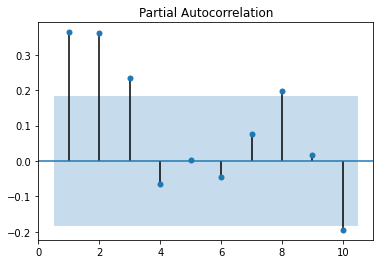

In [19]:
plot_pacf(df.IsCanceled, lags=10, zero=False);

### Moving Average

In [20]:
window_size = 4

numbers_series = pd.Series(tseries)
windows = numbers_series.rolling(window_size)
moving_averages = windows.mean()

moving_averages_list = moving_averages.tolist()
ts4 = moving_averages_list[window_size - 1:]
ts4=np.array(ts4)
print(ts4)

[ 62.5   77.5   82.5   84.75  83.5   80.25 100.25  95.25 124.5  133.25
 119.   149.5  107.    99.75  88.    49.75  59.25  51.5   45.    65.5
  58.    51.5   66.75  45.75  48.5   49.25  33.    25.75  20.75  25.
  65.5   70.25  99.75 107.5   75.5   83.5   79.75  74.    82.    90.25
  89.75 129.   128.75 140.   146.25 111.25 116.25  99.75  92.    90.25
  85.5   85.    87.25  98.5  103.   115.25 122.75 129.   134.   129.5
 122.5  103.   105.75 107.25 106.5  111.   124.25 129.75 128.   124.25
  88.5   69.75  60.5   57.25  56.5   62.75  68.    67.25  68.75  58.5
  47.5   46.75  59.    72.25  91.5   98.   106.75 103.5   83.75  90.75
  86.5  110.5  124.25 124.5  139.   120.75 114.5  120.5  129.25 132.
 150.25 150.5  140.25 143.75 140.5  145.25 144.25 154.75 155.   163.
 159.5  141.25]


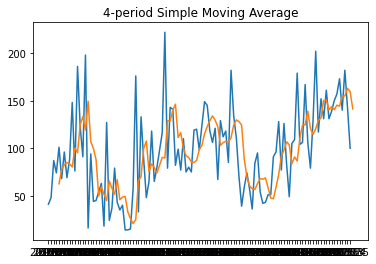

In [21]:
n1=math.nan
n4=np.array([n1,n1,n1,n1])
ts4=np.concatenate([n4,ts4])
plt.plot(tseries)
plt.plot(ts4)
plt.title("4-period Simple Moving Average")
plt.show()

### Train-Test Split

In [22]:
tseriesr=pd.Series(tseries)
type(tseriesr)
train, test = tseriesr[1:103], tseriesr[104:115]

In [23]:
type(test)

pandas.core.series.Series

In [24]:
train

FullDate
201528     48.0
201529     87.0
201530     74.0
201531    101.0
201532     68.0
          ...  
201719    106.0
201720     79.0
201721    130.0
201722    202.0
201723    117.0
Name: IsCanceled, Length: 102, dtype: float64

In [25]:
test

FullDate
201725    131.0
201726    161.0
201727    131.0
201728    139.0
201729    150.0
201730    157.0
201731    173.0
201732    140.0
201733    182.0
201734    143.0
201735    100.0
Name: IsCanceled, dtype: float64

# Milestone 3


### auto_arima

Looking at the autocorrelation function, the correlation drops off after 51 lags.

In this regard, the seasonal factor (m) is set to **51** in the ARIMA configuration below.

In [26]:
Arima_model=pm.auto_arima(train, start_p=0, start_q=0, max_p=10, max_q=10, start_P=0, start_Q=0, max_P=10, max_Q=10, m=51, stepwise=True, seasonal=True, information_criterion='bic', trace=True, d=1, D=1, error_action='warn', suppress_warnings=True, random_state = 20, n_fits=30)

Performing stepwise search to minimize bic
 ARIMA(0,1,0)(0,1,0)[51]             : BIC=578.579, Time=0.31 sec
 ARIMA(1,1,0)(1,1,0)[51]             : BIC=568.064, Time=2.41 sec
 ARIMA(0,1,1)(0,1,1)[51]             : BIC=inf, Time=6.20 sec
 ARIMA(1,1,0)(0,1,0)[51]             : BIC=564.152, Time=0.32 sec
 ARIMA(1,1,0)(0,1,1)[51]             : BIC=568.064, Time=2.44 sec
 ARIMA(1,1,0)(1,1,1)[51]             : BIC=571.976, Time=3.17 sec
 ARIMA(2,1,0)(0,1,0)[51]             : BIC=561.339, Time=0.48 sec
 ARIMA(2,1,0)(1,1,0)[51]             : BIC=inf, Time=12.47 sec
 ARIMA(2,1,0)(0,1,1)[51]             : BIC=inf, Time=24.18 sec
 ARIMA(2,1,0)(1,1,1)[51]             : BIC=inf, Time=34.20 sec
 ARIMA(3,1,0)(0,1,0)[51]             : BIC=565.160, Time=1.42 sec
 ARIMA(2,1,1)(0,1,0)[51]             : BIC=inf, Time=3.74 sec
 ARIMA(1,1,1)(0,1,0)[51]             : BIC=inf, Time=1.78 sec
 ARIMA(3,1,1)(0,1,0)[51]             : BIC=inf, Time=2.88 sec
 ARIMA(2,1,0)(0,1,0)[51] intercept   : BIC=565.202, Time=1

In [27]:
Arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  102
Model:             SARIMAX(2, 1, 0)x(0, 1, 0, 51)   Log Likelihood                -274.801
Date:                            Mon, 07 Dec 2020   AIC                            555.603
Time:                                    16:24:35   BIC                            561.339
Sample:                                         0   HQIC                           557.787
                                            - 102                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7571      0.169     -4.474      0.000      -1.089      -0.425
ar.L2         -0.3576      0.170     -2.098      0.036      -0.692      -0.024
sigma2      3433.5023    599.108      5.731      0.000    2259.273    4607.732
===================================================================================
Ljung-Box (Q):                       44.89   Jarque-Bera (JB):                 4.55
Prob(Q):                              0.27   Prob(JB):                         0.10
Heteroskedasticity (H):               1.43   Skew:                            -0.58
Prob(H) (two-sided):                  0.47   Kurtosis:                         3.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
prediction=pd.DataFrame(Arima_model.predict(n_periods=11), index=test.index)
prediction.columns = ['Predicted_Cancellations']
predictions=prediction['Predicted_Cancellations']

In [29]:
prediction

,Predicted_Cancellations
FullDate,
201725,137.728373
201726,142.730112
201727,117.800906
201728,176.889361
201729,173.591858
201730,149.450168
201731,178.608457
201732,201.983055
201733,198.084330


In [30]:
test

FullDate
201725    131.0
201726    161.0
201727    131.0
201728    139.0
201729    150.0
201730    157.0
201731    173.0
201732    140.0
201733    182.0
201734    143.0
201735    100.0
Name: IsCanceled, dtype: float64

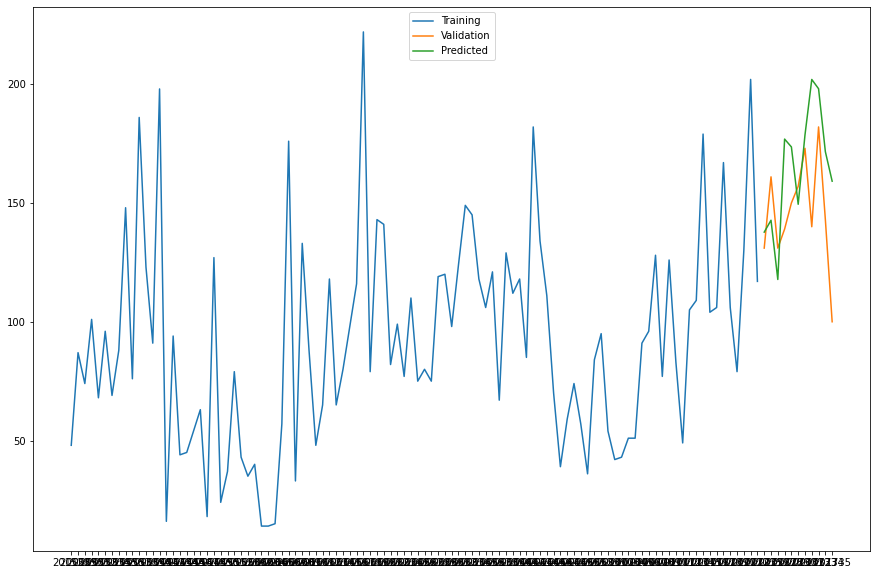

In [31]:
plt.figure(figsize=(15,10))
plt.plot(train, label='Training')
plt.plot(test, label='Validation')
plt.plot(prediction, label='Predicted')
plt.legend(loc = 'upper center')
plt.show()

### Calculate Test RMSE

In [32]:
mse = mean_squared_error(test, predictions)
rmse = math.sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 31.698875


In [33]:
np.mean(test)

146.0909090909091

### Interpretation

The most suitable ARIMA model under this circumstance was identified as **ARIMA(2,1,0)(0,1,0)[51]**, with a BIC of **561.339**.

The RMSE of 31 is 21% the size of the mean weekly cancellations of 146 for the test set. While a lower RMSE would be preferable, too low an RMSE value would potentially indicate that the model has been "over-trained" on the training set and will do well in forecasting the test set in question, but may perform poorly when it comes to forecasting subsequent data. Therefore, while RMSE is important, it is not regarded as the "be all and end all" when it comes to making accurate forecasts.

Given that a visual scan of the predictions indicate that the model is capturing the shift in trends across different periods, this is an indication that the model is working well for these purposes. 